# Pass Length
- Offenses should throw longer passes (if the goal is to avoid tackles):
  Receivers who catch longer passes are at lower risk of being tackled than
  receivers who catch shorter passes.

  
Authors:

- Sean Shi (CSCI 4502)
- Tim Tripp (CSCI 5502)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Prepare the datasets

In [2]:
df = pd.read_csv('../data/tackles.csv')
# In the NFL, normally one defender is credited with a tackle, but often there
# are multiple people involved with the tackle. Here they've been given the
# "assist" role.
tackles = df[(df['tackle'] == 1) | (df['assist'] == 1)]
tackles.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0


In [3]:
tackles = pd.read_csv("../data/tackles.csv")
plays = pd.read_csv("../data/plays.csv")
games = pd.read_csv("../data/games.csv")
players = pd.read_csv("../data/players.csv")
tracking_weeks = [pd.read_csv(f"../data/tracking_week_{i}_filtered.csv") for i in range(1, 10)]
agg = tackles.join(games.set_index("gameId"), on = "gameId")
agg = agg.join(players.set_index("nflId"), on = "nflId")
agg = agg.join(plays.set_index(["playId", "gameId"]), on = ["playId", "gameId"], how = "inner")
agg = agg.join(players.set_index("nflId"), on = "ballCarrierId", rsuffix = "_carrier")
agg

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,season,week,gameDate,...,foulName1,foulName2,foulNFLId1,foulNFLId2,height_carrier,weight_carrier,birthDate_carrier,collegeName_carrier,position_carrier,displayName_carrier
0,2022090800,101,42816,1,0,0,0,2022,1,09/08/2022,...,NaN,NaN,NaN,NaN,5-7,203,1997-09-03,Florida Atlantic,RB,Devin Singletary
1,2022090800,393,46232,1,0,0,0,2022,1,09/08/2022,...,NaN,NaN,NaN,NaN,5-8,200,1997-08-19,Memphis,RB,Darrell Henderson
2,2022090800,486,40166,1,0,0,0,2022,1,09/08/2022,...,NaN,NaN,NaN,NaN,6-2,208,1993-06-15,Eastern Washington,WR,Cooper Kupp
3,2022090800,646,47939,1,0,0,0,2022,1,09/08/2022,...,Horse Collar Tackle,NaN,47939.0,NaN,6-4,254,1996-11-14,Mississippi,TE,Dawson Knox
4,2022090800,818,40107,1,0,0,0,2022,1,09/08/2022,...,NaN,NaN,NaN,NaN,5-8,200,1997-08-19,Memphis,RB,Darrell Henderson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17421,2022091113,2494,43533,0,0,0,1,2022,1,09/11/2022,...,NaN,NaN,NaN,NaN,6-0,228,1995-01-18,Louisiana State,RB,Leonard Fournette
17422,2022092502,3510,42406,0,0,0,1,2022,3,09/25/2022,...,NaN,NaN,NaN,NaN,5-9,198,1996-11-12,North Carolina State,RB,Nyheim Hines
17423,2022091113,3642,43478,0,0,0,1,2022,1,09/11/2022,...,NaN,NaN,NaN,NaN,6-2,210,NaN,Arizona State,RB,Rachaad White
17424,2022091901,3578,42431,0,0,0,1,2022,2,09/19/2022,...,NaN,NaN,NaN,NaN,5-11,211,1997-05-01,Penn State,RB,Miles Sanders


In [4]:
plays = pd.read_csv('../data/plays.csv').set_index(['gameId', 'playId'])
# Joining with plays allows us to get information such as the offensive
# formation, whether a pass was successful, etc.
tackle_plays = tackles.join(
    other = plays,
    on = ['gameId', 'playId'],
    how = 'inner'
)
tackle_plays.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,ballCarrierId,ballCarrierDisplayName,playDescription,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022090800,101,42816,1,0,0,0,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,...,0.399819,0.600181,-0.014850,0.014850,2.126690,0.562363,NaN,NaN,NaN,NaN
1,2022090800,393,46232,1,0,0,0,47853,Darrell Henderson,(7:45) (Shotgun) D.Henderson right guard to LA...,...,0.314065,0.685935,-0.015263,0.015263,2.458136,-0.386335,NaN,NaN,NaN,NaN
2,2022090800,486,40166,1,0,0,0,44881,Cooper Kupp,"(5:53) (No Huddle, Shotgun) M.Stafford pass sh...",...,0.272012,0.727988,-0.016078,0.016078,0.825719,-1.041838,NaN,NaN,NaN,NaN
3,2022090800,646,47939,1,0,0,0,47879,Dawson Knox,(1:53) J.Allen pass short left to D.Knox to LA...,...,0.204260,0.795740,-0.029484,0.029484,2.706385,1.352469,Horse Collar Tackle,NaN,47939.0,NaN
4,2022090800,818,40107,1,0,0,0,47853,Darrell Henderson,(15:00) (Shotgun) M.Stafford pass short left t...,...,0.250420,0.749580,-0.017527,0.017527,0.215741,-1.372731,NaN,NaN,NaN,NaN


## Hypothesis 2

Offenses should use heavier running backs: Heavier running backs result in more missed tackles, as they're harder for would-be tacklers to bring down.

In [5]:
df_runningbacks = players[players.position == 'RB']
df_runningbacks.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
32,37101,5-9,215,1989-12-21,Alabama,RB,Mark Ingram
76,39212,5-11,220,1990-01-26,Mississippi,RB,Brandon Bolden
84,39975,6-2,238,1991-03-17,Tennessee,RB,Cordarrelle Patterson
109,40129,6-3,230,1990-01-18,Central Florida,RB,Latavius Murray
110,40138,5-10,215,1990-07-02,Nebraska,RB,Rex Burkhead


For a comparison, let's see what the weight distribution is for some other offensive positions.

(array([2.600e+01, 3.700e+01, 1.400e+02, 2.220e+02, 3.290e+02, 3.500e+02,
        7.020e+02, 4.110e+02, 3.510e+02, 4.210e+02, 5.170e+02, 5.780e+02,
        1.003e+03, 2.420e+02, 1.650e+02, 1.580e+02, 1.230e+02, 1.430e+02,
        2.750e+02, 1.300e+02, 1.220e+02, 9.500e+01, 8.300e+01, 5.600e+01,
        1.120e+02, 4.100e+01, 2.100e+01, 2.200e+01, 1.000e+01, 1.500e+01,
        2.600e+01, 8.000e+00, 4.000e+00, 7.000e+00, 5.000e+00, 6.000e+00,
        9.000e+00, 4.000e+00, 6.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        1.000e+01, 5.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([-9.        , -7.83333333, -6.66666667, -5.5       , -4.33333333,
        -3.16666667, -2.        , -0.83333333,  0.33333333,  1.5       ,
         2.66666667,  3.83333333,  5.        ,  6.16666667,  7.33333333,
         8.5       ,  9.66666667, 10.83

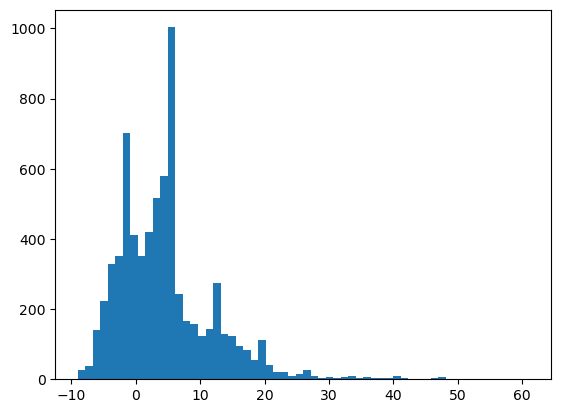

In [6]:
plt.hist(agg.passLength, bins = 60)
# agg.passLength.summary()

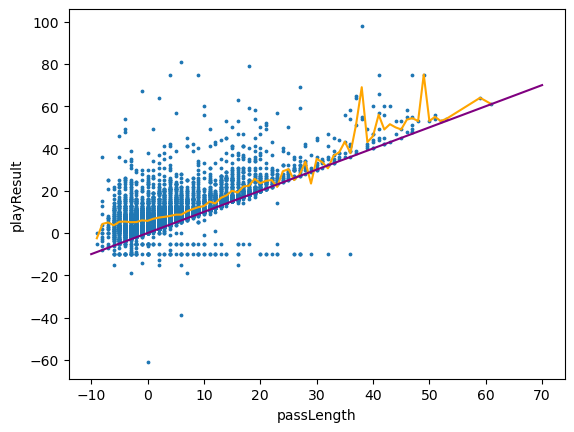

In [7]:
grouped = plays.join(players.set_index("nflId"), on = "ballCarrierId").groupby("passLength")
x = [passLength for passLength, _ in grouped]
y = [df.playResult.mean() for passLength, df in grouped]
plt.scatter(plays.passLength, plays.playResult, s=3)
plt.xlabel("passLength")
plt.ylabel("playResult")
plt.plot(x,y, color = "orange")
plt.plot((-10,70), (-10, 70), color = "purple")

From the graph above, we can draw several conclusions: 
- in general, the pass length is at minimum the length for the play result
- the vast majority of pass lengths tend to be below 20 and clustered around 0
- running doesn't work as well as throwing further

Outliers:
- there are several points in the plot where pass length is less than the play result
  - the lines observed at -5 and -10 are most likely due to penalties
  - the plays which are lower than the line are likely due to an interception and another team's player taking the ball
  - there are several points which represent the carrier running very far before being stopped either by tackle or going out of bounds

In [8]:
plays['yardsBeforeTackle'] = plays.playResult - plays.passLength
grouped = plays.join(players.set_index("nflId"), on = "ballCarrierId").groupby("passLength")
p = plays[~plays.passLength.isna()]
reg = LinearRegression().fit(p[["passLength"]], p.yardsBeforeTackle)
f"slope: {reg.coef_}, intercept: {reg.intercept_}, score: {reg.score(p[["passLength"]], p[["yardsBeforeTackle"]])}"

'slope: [-0.14727129], intercept: 5.887464027604458, score: 0.02560144947410159'

In [9]:
p1 = (-10,70)
p2 = (reg.predict([[p1[0]]])[0], reg.predict([[p1[1]]])[0])

/usr/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


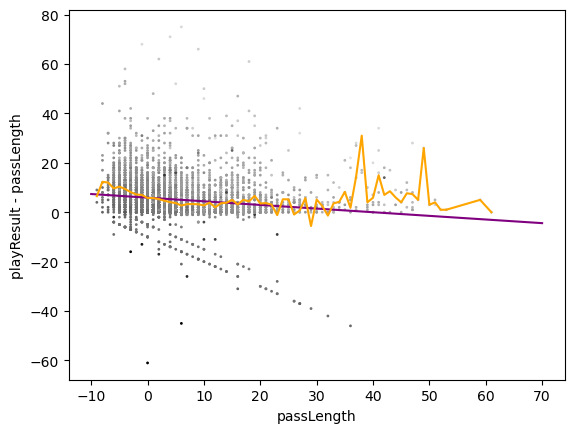

In [10]:
# y = [df.playResult.mean() - df.passLength.mean() for passLength, df in grouped]
s = plays.join(players.set_index("nflId"), on = "ballCarrierId", rsuffix = "_carrier").weight
y = [df.yardsBeforeTackle.mean() for passLength, df in grouped]
plt.scatter(plays.passLength, plays.yardsBeforeTackle, s=1, c=plays.expectedPointsAdded, cmap='gray')
plt.xlabel("passLength")
plt.ylabel("playResult - passLength")
plt.plot(p1, p2, color = "purple")
plt.plot(x,y, color = "orange")

By subtracting play result from pass length, we can get the number of yards the ball carrier was able to go before being tackled or otherwise stopped. The graph below also shows some other attributes:
- size: weight of players
- color: expected points added

We can draw some of the following conclusions from this graph:
- in the range approximately (-8,5), the distance the carrier is traveling starts high and decreases
- expectedPointsAdded is highly correlated to play result.
  - most times when the ball is stolen tend to result in significant decreases in the expected points added(losing confidence)
  - there are some values which do not fit this description so the prediction algorithm used likely has more inputs
- weight does not seem to have a significant effect on distance traveled?

In [11]:
players.weight.min()

np.int64(153)

In [12]:
plays['yardsBeforeTackle'] = plays.playResult - plays.passLength
p = plays[~plays.passLength.isna()]
p = plays[plays.passLength < 8 & (plays.passLength > -5)]
reg = LinearRegression().fit(p[["passLength"]], p.yardsBeforeTackle)
f"slope: {reg.coef_}, intercept: {reg.intercept_}, score: {reg.score(p[["passLength"]], p[["yardsBeforeTackle"]])}"

'slope: [-0.76231569], intercept: 6.001859622959177, score: 0.027457778871036176'